In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    roc_curve,
    auc
)
from xgboost import XGBClassifier

# Set style for seaborn
sns.set(style="whitegrid")

# Load the CSV file
file_path = r'C:\Users\Hubert N\Downloads\8.31.22 STAR Data Spreadsheet (2).csv'
df = pd.read_csv(file_path)

# Filter relevant columns
columns_of_interest = [
    "Sex (0 = female; 1 = male)",
    "Neuter status (0 = castrated; 1 = not castrated)",
    "Age",
    "Duration of U-cath placement (days)",
    "U-cath placement (no = 0; yes = 1)",
    "Number of vet visits",
    'Collection Type (Cysto = 0; other =1; unknown = 2)',
    'Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)',
    'Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)',
    'USG', 'PH', 'Protein', 'Glucose', 'Ketones', 
    'Bilirubin', 'Hemoprotein', 'Sediment Vol', 'Volume', 
    'Lipid Layer', 'WBC (simplified)', 'Pyuria (1 if >/=4)', 
    'RBC (simplified)', 'Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)',  
    'Triple Phos', 'Bilirubin.1',
    'Epithelial Cells-Transitional', 'Epithelial Cells-Squamous', 
    'Epithelial Cells-Renal', 'Epithelial Cells-Caudate', 
    'Casts-Hyaline', 'Casts-Granular',  
    'Bacteria quantity', 'Bac Type', 'Lipid Droplets', 'Sperm'
]

# Check if all columns of interest are in the DataFrame
missing_columns = [col for col in columns_of_interest if col not in df.columns]
if missing_columns:
    print("Missing columns:", missing_columns)
else:
    # Select features
    features = df[columns_of_interest]

    # Replace missing values with the mean
    features = features.fillna(features.mean())

    # Clean the target variable (Ampicillin resistance)
    df = df[df["Ampicillin"].isin(["R", "S"])]  # Keep only rows with 'R' or 'S'
    df = df.replace({"Ampicillin": {"R": 1, "S": 0}})
    target = df["Ampicillin"]

    # Ensure the target is numeric
    target = target.dropna().astype(int)

    # Ensure that features and target have the same indices
    features = features.loc[target.index]

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert X_train back to DataFrame for resampling
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_of_interest)
    X_train_scaled_df['Ampicillin'] = y_train.reset_index(drop=True)  # Ensure indices align

    # Separate majority and minority classes
    df_majority = X_train_scaled_df[X_train_scaled_df['Ampicillin'] == 0]
    df_minority = X_train_scaled_df[X_train_scaled_df['Ampicillin'] == 1]

    # Upsample minority class
    df_minority_upsampled = resample(
        df_minority, 
        replace=True,     # sample with replacement
        n_samples=len(df_majority),    # to match majority class
        random_state=42   # reproducible results
    )

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Shuffle the upsampled dataset
    df_upsampled = df_upsampled.sample(frac=1, random_state=42)

    # Separate features and target
    X_train_resampled = df_upsampled.drop('Ampicillin', axis=1)
    y_train_resampled = df_upsampled['Ampicillin']

    # Feature Selection using Random Forest Importances
    from sklearn.feature_selection import SelectFromModel

    # Train a Random Forest classifier to get feature importances
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Get feature importances
    importances = rf_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'feature': X_train_resampled.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("Feature Importances:")
    print(feature_importances)

    # Select features with importance greater than a threshold
    threshold = 0.01  # You can adjust this threshold
    selector = SelectFromModel(rf_model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train_resampled)
    X_test_selected = selector.transform(X_test_scaled)
    selected_features = feature_importances[feature_importances['importance'] > threshold]['feature'].tolist()
    print("Selected features:")
    print(selected_features)

    # Calculate scale_pos_weight to handle class imbalance
    scale_pos_weight = sum(y_train_resampled == 0) / sum(y_train_resampled == 1)

    # Initialize XGBoost classifier with scale_pos_weight
    xgb_model = XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Fit the model on the selected features
    xgb_model.fit(X_train_selected, y_train_resampled)

    # Predict on the test set
    y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

Feature Importances:
                                              feature  importance
2                                                 Age    0.115255
9                                                 USG    0.101167
5                                Number of vet visits    0.065033
21                                   RBC (simplified)    0.064622
11                                            Protein    0.056107
17                                             Volume    0.046982
15                                        Hemoprotein    0.045895
10                                                 PH    0.044586
19                                   WBC (simplified)    0.040974
8   Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    0.040493
22  Crystals (0 = none 1 = rare; 2 = few; 3 = mod;...    0.032214
31                                  Bacteria quantity    0.031682
33                                     Lipid Droplets    0.031207
25                      Epithelial Cells-Transitional  

c:\Users\Hubert N\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Hubert N\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their ranges for tuning
param_grid = {
    'n_estimators': [100, 200, 300],               
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}]  # More aggressive class weights
}
rf = RandomForestClassifier(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.4).astype(int)  # Example: threshold of 0.4

accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f"Optimized Model Accuracy: {accuracy_best:.4f}")
print("Optimized Classification Report:")
print(report_best)


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


c:\Users\Hubert N\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Hubert N\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found: {'bootstrap': True, 'class_weight': {0: 1, 1: 20}, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Optimized Model Accuracy: 0.7685
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87        84
           1       0.00      0.00      0.00        24

    accuracy                           0.77       108
   macro avg       0.39      0.49      0.43       108
weighted avg       0.60      0.77      0.68       108



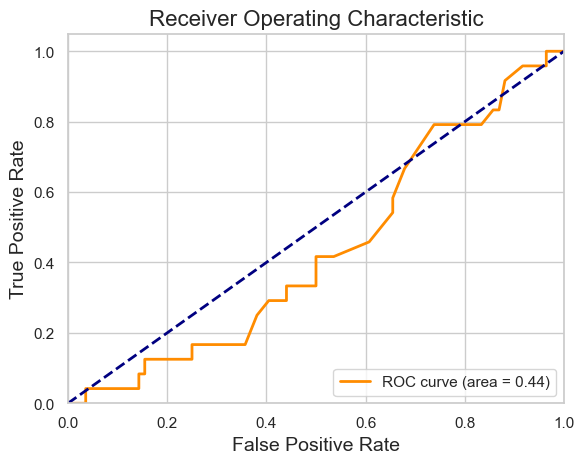

In [20]:
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)  # Calculate AUC score

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right")
plt.show()

In [21]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate Youden's J statistic
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print('Best Threshold=%f, J-Statistic=%.3f' % (best_threshold, J[ix]))

# Predict using the optimal threshold
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized Threshold Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print("Confusion Matrix:")
print(cm)

'''# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()'''


Best Threshold=0.180000, J-Statistic=0.054
Optimized Threshold Accuracy: 0.3796
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.26      0.40        84
           1       0.23      0.79      0.36        24

    accuracy                           0.38       108
   macro avg       0.52      0.53      0.38       108
weighted avg       0.69      0.38      0.39       108

Confusion Matrix:
[[22 62]
 [ 5 19]]


"# Plot Confusion Matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')\nplt.xlabel('Predicted Label', fontsize=14)\nplt.ylabel('True Label', fontsize=14)\nplt.title('Confusion Matrix', fontsize=16)\nplt.show()"

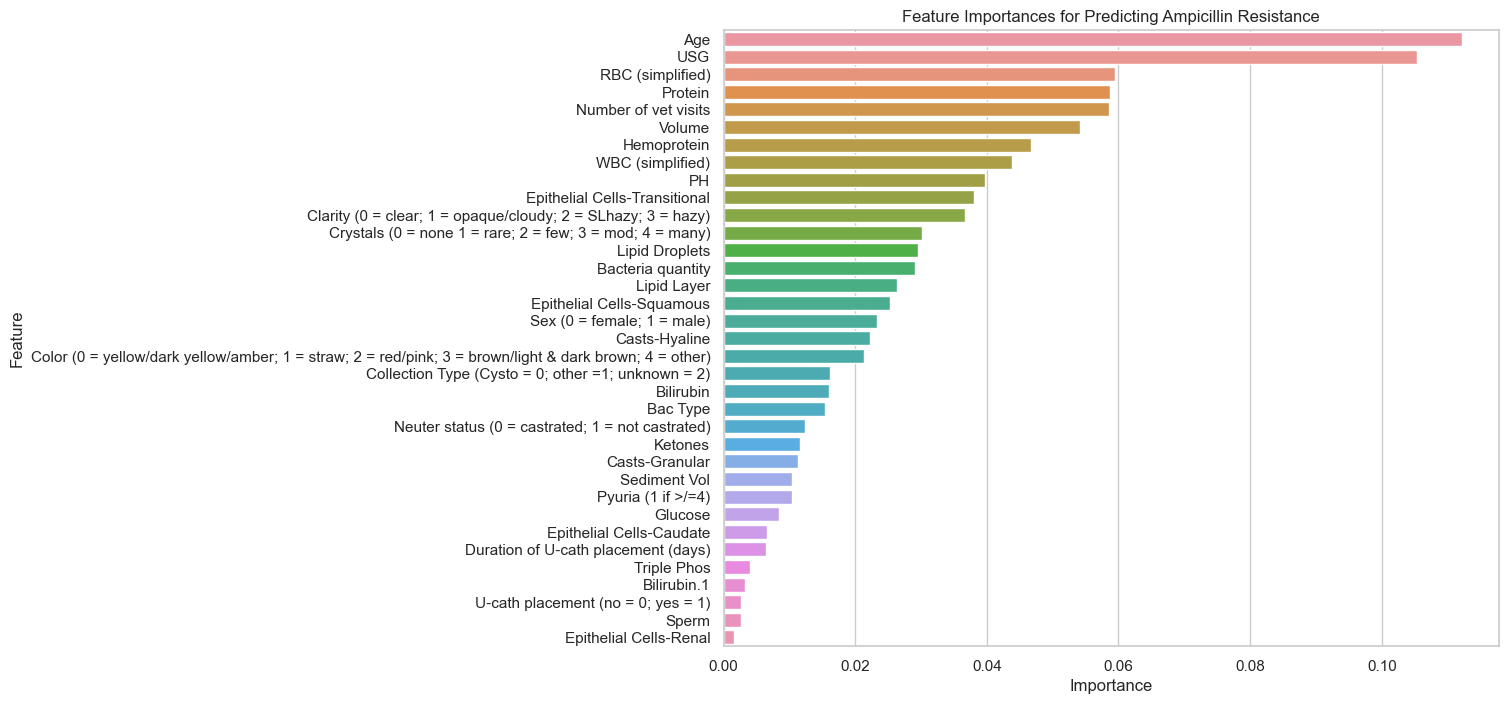

In [22]:
# random forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = features.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances for Predicting Ampicillin Resistance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [23]:
# Hyperparameter Tuning for XGBoost
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'  # Using F1 score for imbalanced data
)

# Fit the grid search to the data
grid_search.fit(X_train_selected, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_selected, y_train_resampled)

# Predict with the optimized model
y_pred_proba = best_xgb_model.predict_proba(X_test_selected)[:, 1]
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized XGBoost Model Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print("Confusion Matrix:")
print(cm)

'''
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Optimized Confusion Matrix', fontsize=16)
plt.show()
'''

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\Hubert N\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Optimized XGBoost Model Accuracy: 0.5463
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64        84
           1       0.27      0.62      0.38        24

    accuracy                           0.55       108
   macro avg       0.55      0.57      0.51       108
weighted avg       0.71      0.55      0.58       108

Confusion Matrix:
[[44 40]
 [ 9 15]]


"\n# Plot Confusion Matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')\nplt.xlabel('Predicted Label', fontsize=14)\nplt.ylabel('True Label', fontsize=14)\nplt.title('Optimized Confusion Matrix', fontsize=16)\nplt.show()\n"

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\Hubert N\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


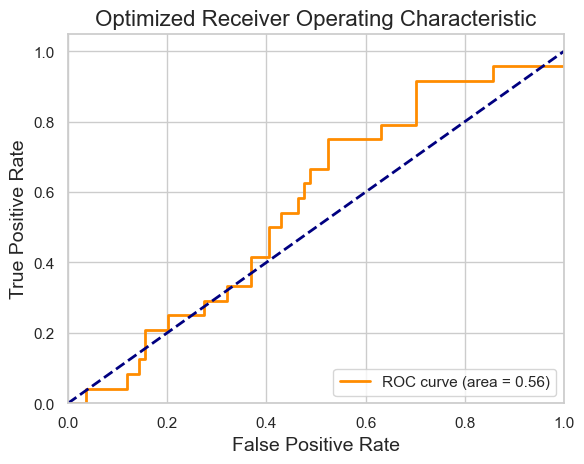

In [27]:
# Fit the grid search to the data
grid_search.fit(X_train_selected, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_selected, y_train_resampled)

# Predict with the optimized model
y_pred_proba_best = best_xgb_model.predict_proba(X_test_selected)[:, 1]

# Compute ROC curve and AUC score for the optimized model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Plot ROC Curve for the optimized model
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Optimized Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right")
plt.show()